# Feedforward Neural Network (FNN) using Keras

## 1. Tools and Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

## 2. Loading and Preprocessing the Dataset

In [ ]:
# Load the dataset
heart_df = pd.read_csv('heart.csv')

In [10]:
# Encode categorical features using One-Hot Encoding
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(heart_df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
modified_df = pd.concat([heart_df.drop(categorical_features, axis=1), encoded_df], axis=1)

In [11]:
# Split the dataset into training, validation, and test sets
X = modified_df.drop('HeartDisease', axis=1)
y = modified_df['HeartDisease']

# Split the dataset into training, validation (80%) and test (20%) sets, maintaining class distribution
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training set into training (70%) and validation (10%) sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [12]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 3. Building the Neural Network Model

In [13]:
# Initialize the neural network
network = models.Sequential()

# Add the hidden layer with ReLU activation function
network.add(layers.Dense(16, activation='relu', input_shape=(X.shape[1],)))

# Add the output layer with sigmoid activation function
network.add(layers.Dense(1, activation='sigmoid'))

# Add SGD optimizer with learning rate 0.01
optimizer = optimizers.SGD(learning_rate=0.01)

# Compile the network with binary cross-entropy loss function
network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the network
history = network.fit(X_train_scaled, 
                      y_train,
                      epochs=50,
                      verbose=1)

# Evaluate the network
test_loss, test_accuracy = network.evaluate(X_test_scaled, y_test)
print(f'Test loss before tuning: {test_loss}')
print(f'Test accuracy before tuning: {test_accuracy}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6130 - loss: 0.6535   
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - loss: 0.5877 
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7464 - loss: 0.5388 
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.5013 
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8458 - loss: 0.4714 
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8586 - loss: 0.4474 
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.4280 
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.4119 
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8716 - loss: 0.3986 
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8720 - loss: 0.3873 
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.3777 
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - 

## 4. Hyperparameter Tuning

In [14]:
# Tuning the hyperparameters
learning_rates = [0.001, 0.01, 0.1]
hidden_units = [8, 16, 32]
epochs = [50, 100, 200, 500]

best_accuracy = 0
best_hyperparameters = None

for lr in learning_rates:
    for n_neurons in hidden_units:
        for n_epochs in epochs:
            network = models.Sequential()
            network.add(layers.Dense(n_neurons, activation='relu', input_shape=(X.shape[1],)))
            network.add(layers.Dense(1, activation='sigmoid'))
            optimizer = optimizers.SGD(learning_rate=lr)
            network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
            history = network.fit(X_train_scaled, 
                                    y_train, 
                                    epochs=n_epochs, 
                                    verbose=0, 
                                    callbacks=[early_stopping],
                                    validation_data=(X_val_scaled, y_val))
            val_loss, val_accuracy = network.evaluate(X_val_scaled, y_val, verbose=0)
            print(f'lr={lr}, n_neurons={n_neurons}, n_epochs={n_epochs}, val_accuracy={val_accuracy}')
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = (lr, n_neurons, n_epochs)

print(f"Best hyperparameters: lr={best_hyperparameters[0]}, n_neurons={best_hyperparameters[1]}, n_epochs={best_hyperparameters[2]}")

lr=0.001, n_neurons=8, n_epochs=50, val_accuracy=0.6413043737411499
lr=0.001, n_neurons=8, n_epochs=100, val_accuracy=0.8369565010070801
lr=0.001, n_neurons=8, n_epochs=200, val_accuracy=0.782608687877655
lr=0.001, n_neurons=8, n_epochs=500, val_accuracy=0.79347825050354
lr=0.001, n_neurons=16, n_epochs=50, val_accuracy=0.804347813129425
lr=0.001, n_neurons=16, n_epochs=100, val_accuracy=0.782608687877655
lr=0.001, n_neurons=16, n_epochs=200, val_accuracy=0.8369565010070801
lr=0.001, n_neurons=16, n_epochs=500, val_accuracy=0.79347825050354
lr=0.001, n_neurons=32, n_epochs=50, val_accuracy=0.70652174949646
lr=0.001, n_neurons=32, n_epochs=100, val_accuracy=0.77173912525177
lr=0.001, n_neurons=32, n_epochs=200, val_accuracy=0.804347813129425
lr=0.001, n_neurons=32, n_epochs=500, val_accuracy=0.804347813129425
lr=0.01, n_neurons=8, n_epochs=50, val_accuracy=0.804347813129425
lr=0.01, n_neurons=8, n_epochs=100, val_accuracy=0.804347813129425
lr=0.01, n_neurons=8, n_epochs=200, val_accurac

## 5. Training the Final Model with Optimal Hyperparameters

In [15]:
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar(label='Count')
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3592 - loss: 0.8458 - val_accuracy: 0.5109 - val_loss: 0.7972
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4638 - loss: 0.7472 - val_accuracy: 0.5870 - val_loss: 0.7451
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5779 - loss: 0.6788 - val_accuracy: 0.6196 - val_loss: 0.7089
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6253 - loss: 0.6281 - val_accuracy: 0.6196 - val_loss: 0.6821
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6996 - loss: 0.5892 - val_accuracy: 0.6739 - val_loss: 0.6615
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - loss: 0.5579 - val_accuracy: 0.7174 - val_loss: 0.6447
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7761 - loss: 0.5321 - val_accuracy: 0.7283 - val_loss: 0.6304
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7980 - loss: 0.5101 - val_accuracy: 0.7391 - 

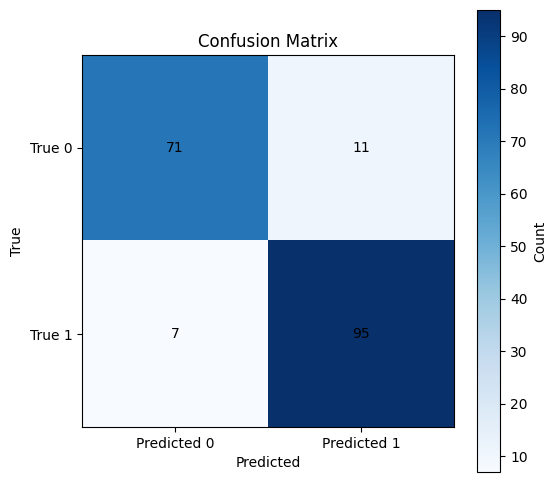

F1 score: 0.9135


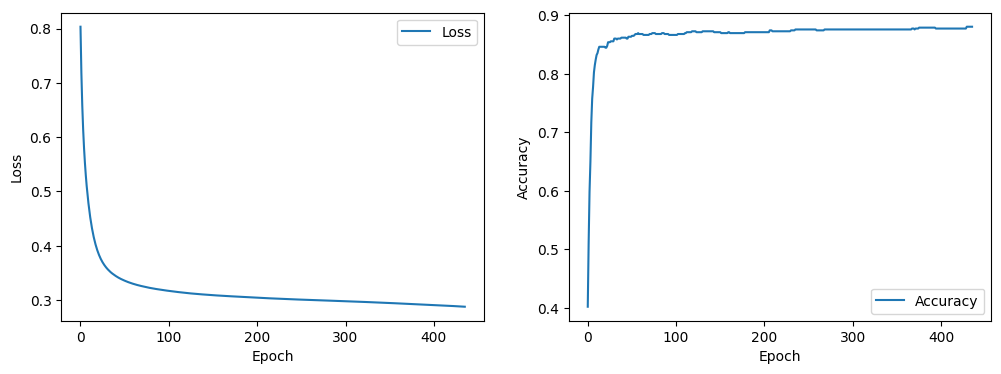

In [16]:
# Initialize the neural network
network = models.Sequential()

# Add the hidden layer with ReLU activation function
network.add(layers.Dense(best_hyperparameters[1], activation='relu', input_shape=(X.shape[1],)))

# Add the output layer with sigmoid activation function
network.add(layers.Dense(1, activation='sigmoid'))

# Add SGD optimizer with learning rate 0.01
optimizer = optimizers.SGD(learning_rate=best_hyperparameters[0])

# Compile the network with binary cross-entropy loss function
network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the network
history = network.fit(X_train_scaled, 
                      y_train,
                      epochs=best_hyperparameters[2],
                      verbose=1,
                      callbacks=[early_stopping],
                      validation_data=(X_val_scaled, y_val))

# Evaluate the network
test_loss, test_accuracy = network.evaluate(X_test_scaled, y_test)
print(f'Test loss after tuning: {test_loss}')
print(f'Test accuracy after tuning: {test_accuracy}')

y_pred_prob = network.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()